In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

# Define the CNN model
class SimpleCNN(nn.Module):
	def __init__(self):
		super(SimpleCNN, self).__init__()
		self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
		self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
		self.fc1 = nn.Linear(64 * 7 * 7, 128)
		self.fc2 = nn.Linear(128, 10)
		self.relu = nn.ReLU()
		self.dropout = nn.Dropout(0.25)

	def forward(self, x):
		x = self.pool(self.relu(self.conv1(x)))
		x = self.pool(self.relu(self.conv2(x)))
		x = x.view(-1, 64 * 7 * 7)
		x = self.relu(self.fc1(x))
		x = self.dropout(x)
		x = self.fc2(x)
		return x

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 5
for epoch in range(num_epochs):
	model.train()
	running_loss = 0.0
	for images, labels in train_loader:
		optimizer.zero_grad()
		outputs = model(images)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()
		running_loss += loss.item()
	
	print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Testing the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
	for images, labels in test_loader:
		outputs = model(images)
		_, predicted = torch.max(outputs.data, 1)
		total += labels.size(0)
		correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%")

Epoch [1/5], Loss: 0.1835
Epoch [2/5], Loss: 0.0581
Epoch [3/5], Loss: 0.0429
Epoch [4/5], Loss: 0.0314
Epoch [5/5], Loss: 0.0250
Accuracy of the model on the 10000 test images: 99.25%


In [2]:
def save_model(model, path):
	torch.save(model.state_dict(), path)
 
def load_model(model, path):
	model.load_state_dict(torch.load(path))

In [3]:
save_model(model, 'mnist_cnn.pth')

In [4]:
model = SimpleCNN()
load_model(model, 'mnist_cnn.pth')

C:\Users\DELL\AppData\Local\Temp\ipykernel_22724\920606381.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [53]:
from pyhessian import hessian
from matplotlib import pyplot as plt

def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb


def get_classwise_loss(model, images, labels, n_classes):
	class_losses = torch.zeros(n_classes)
	class_counts = torch.zeros(n_classes)
	model.eval()

	with torch.no_grad():
		outputs = model(images)
		for i in range(10):
			class_mask = (labels == i)
			if class_mask.sum() > 0:
				class_loss = criterion(outputs[class_mask], labels[class_mask])
				class_losses[i] += class_loss.item() * class_mask.sum().item()
				class_counts[i] += class_mask.sum().item()
	class_losses /= class_counts
	return class_losses


class Hessian_model:
	def __init__(self, model, data, loss, n_classes=10):
		self.model = model
		self.criterion = loss
		self.n_classes = n_classes
		self.images, self.labels = data
		self.hessian_comp = hessian(model, self.criterion, data=data, cuda=False)

	def get_hessian(self):
		return self.hessian_comp

	def get_eigenvalues_eigenvectors(self, n=10):
		return self.hessian_comp.eigenvalues(top_n=n)

	def get_perturbed_model(self, epsilon, direction, model_perb):
		model_perb = get_params(model, model_perb, direction, epsilon)
		return model_perb
		
	def get_classwise_loss(self):
		return get_classwise_loss(self.model, self.images, self.labels, self.n_classes)

	def perturb_and_plot(self, direction, epsilons, title=None):
		perturbed_class_losses_list = []
		model_perb = SimpleCNN()
		original_class_losses = self.get_classwise_loss()
		for e in epsilons:
			model_perb = self.get_perturbed_model(e, direction, model_perb)
			perturbed_class_losses = get_classwise_loss(model_perb, self.images, self.labels, self.n_classes)
			perturbed_class_losses_list.append(perturbed_class_losses)
		perturbed_class_losses_tensor = torch.stack(perturbed_class_losses_list)

		fig, axes = plt.subplots(2, 5, figsize=(20, 10))
		if title:
			fig.suptitle(title)
		axes = axes.flatten()

		for i in range(10):
			axes[i].plot(epsilons, perturbed_class_losses_tensor[:, i].numpy() - original_class_losses[i].numpy())
			axes[i].set_title(f'Class {i}')
			axes[i].set_xlabel('Alpha')
			axes[i].set_ylabel('Loss Change')
			axes[i].set_ylim(-0.1, 0.1)  # Set the same scale across all plots

		plt.tight_layout()
		plt.show()
  
	def get_gradient_vector_dot(self, v):
		self.model.zero_grad()
		outputs = self.model(self.images)
		loss = self.criterion(outputs, self.labels)
		loss.backward()
		dot = 0
		for p, v_ in zip(self.model.parameters(), v):
			dot += torch.dot(p.grad.reshape(-1), v_.reshape(-1))
		return dot

In [18]:
hm = Hessian_model(model, images, labels, criterion, 10)

In [52]:
import numpy as np
vals, vects = hm.get_eigenvalues_eigenvectors(10)

original_loss = get_classwise_loss(model, images, labels, 10)

KeyboardInterrupt: 

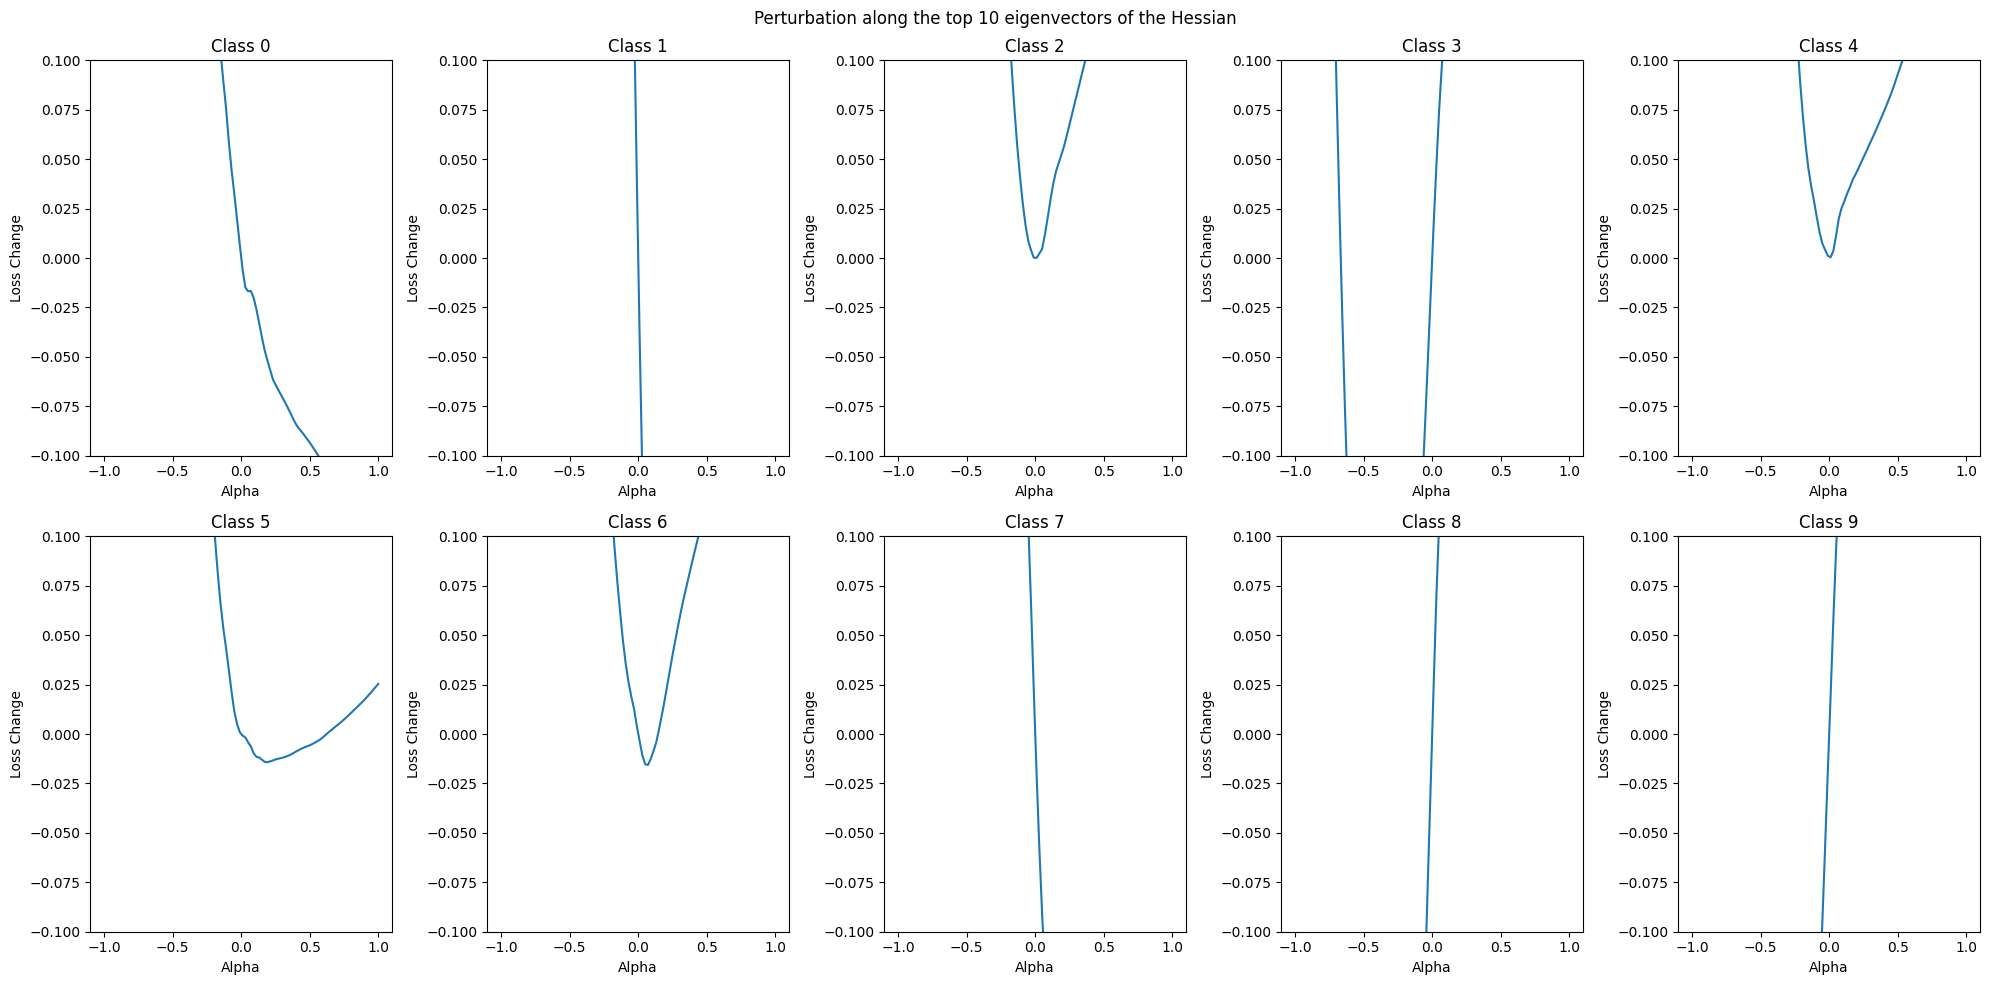

In [46]:
hm.perturb_and_plot(vects[0], np.linspace(-1, 1, 100), title='Perturbation along the top 10 eigenvectors of the Hessian')

In [64]:
model = SimpleCNN()
hm = Hessian_model(model, (images, labels), criterion, 10)

vals, vects = hm.get_eigenvalues_eigenvectors(10)

In [65]:
vals

[5.541697025299072,
 4.513429641723633,
 4.055560111999512,
 4.1168646812438965,
 3.611661195755005,
 3.449232578277588,
 3.0887722969055176,
 3.0309298038482666,
 -2.5098609924316406,
 0.7713004350662231]

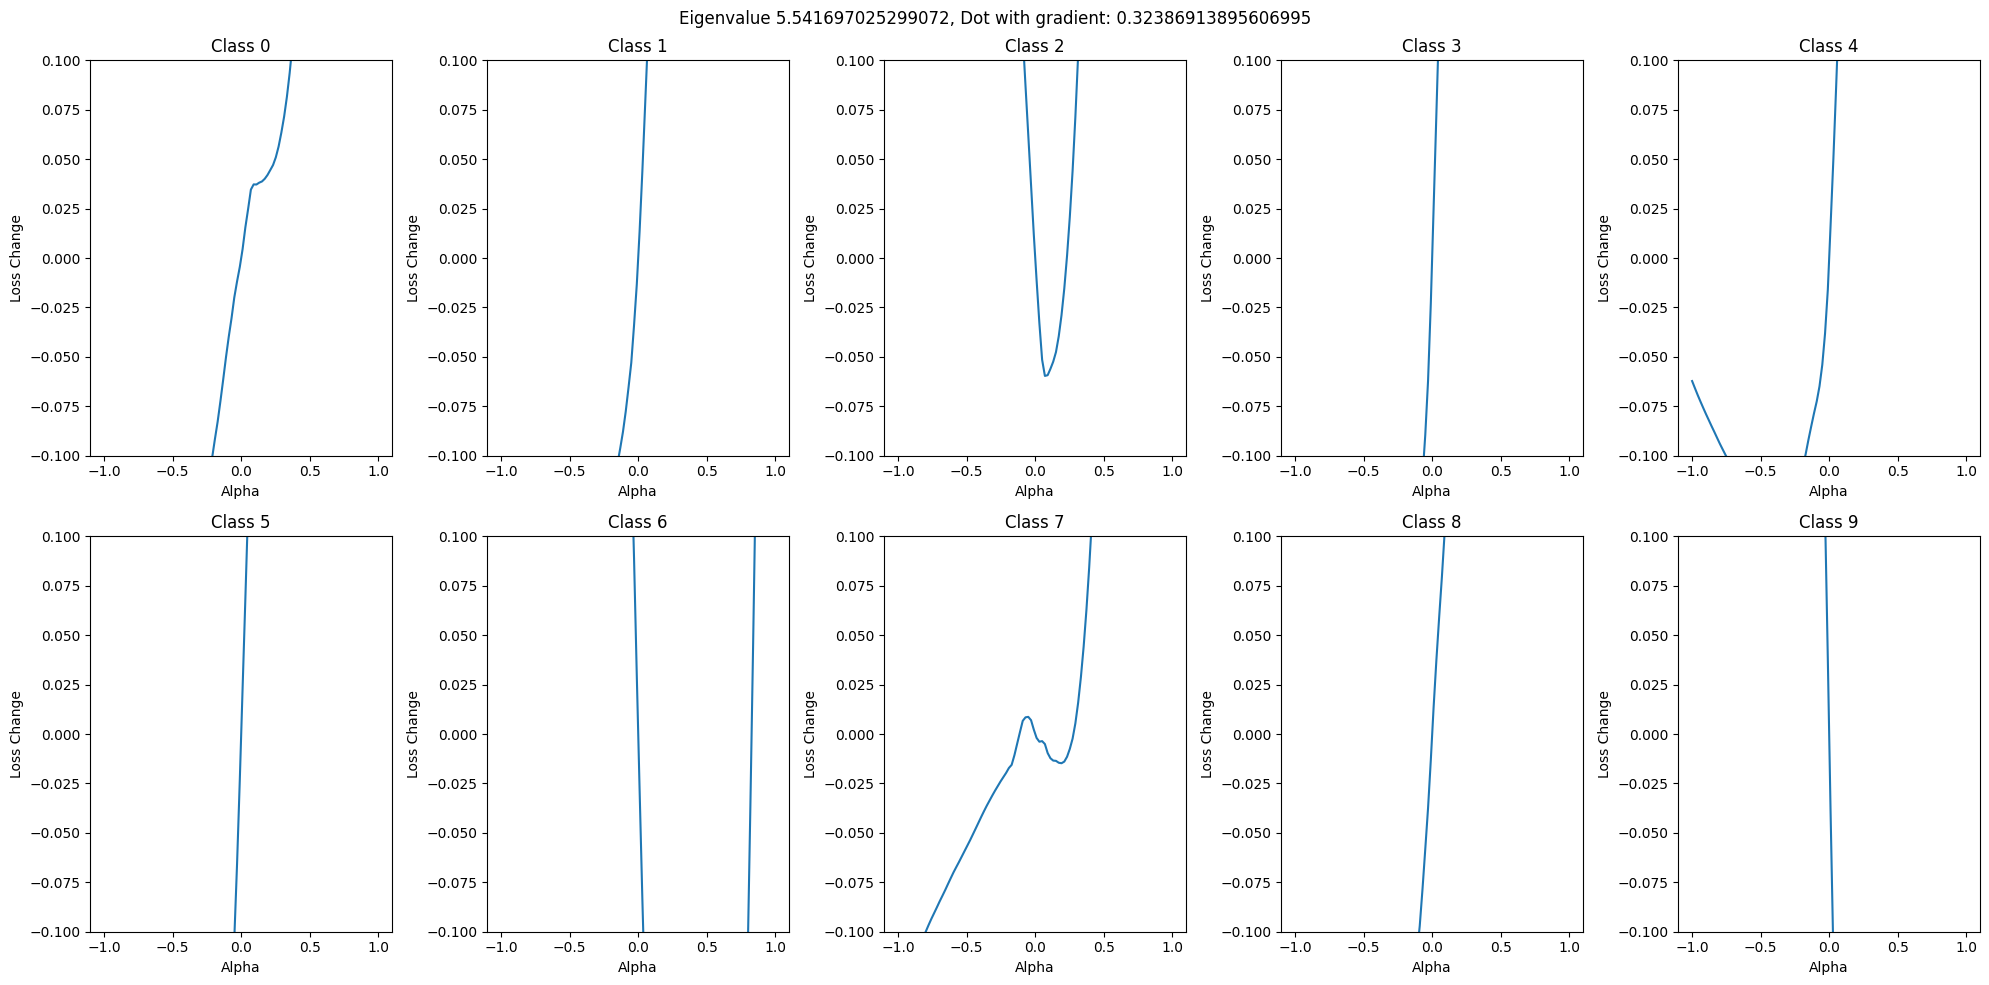

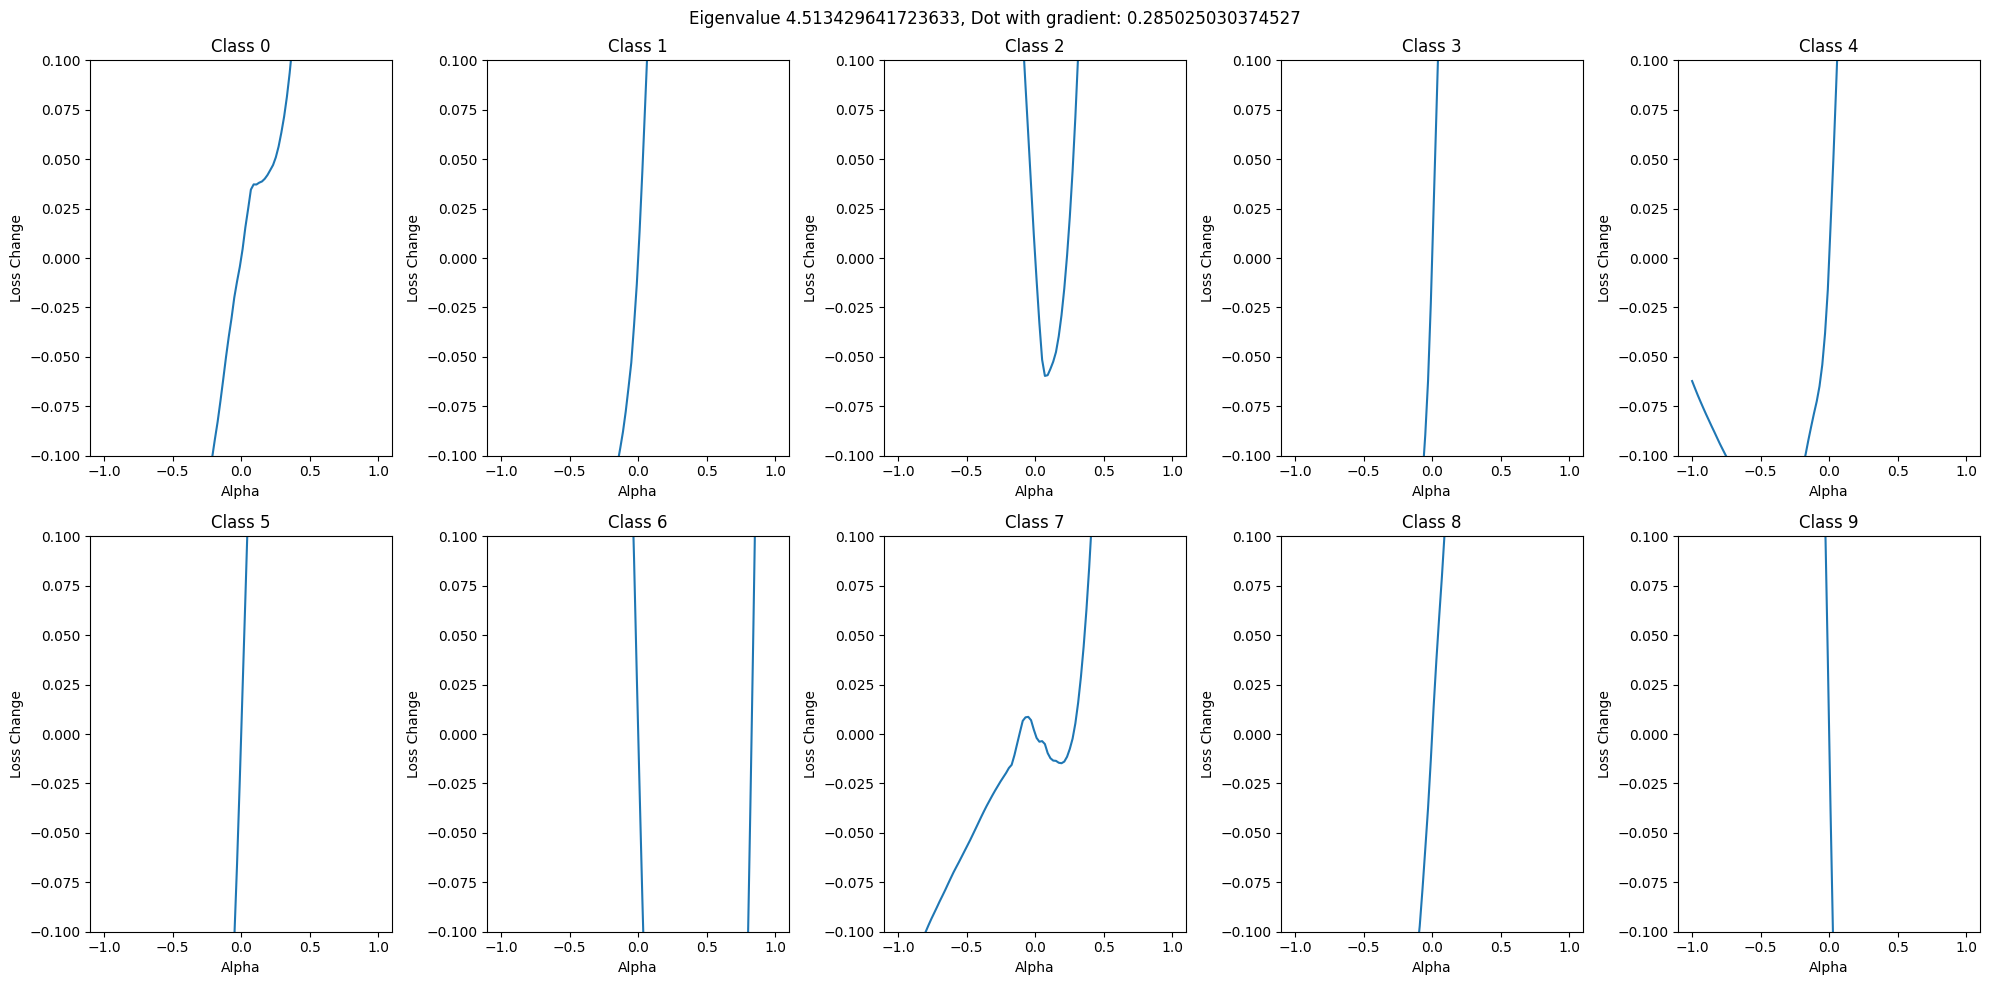

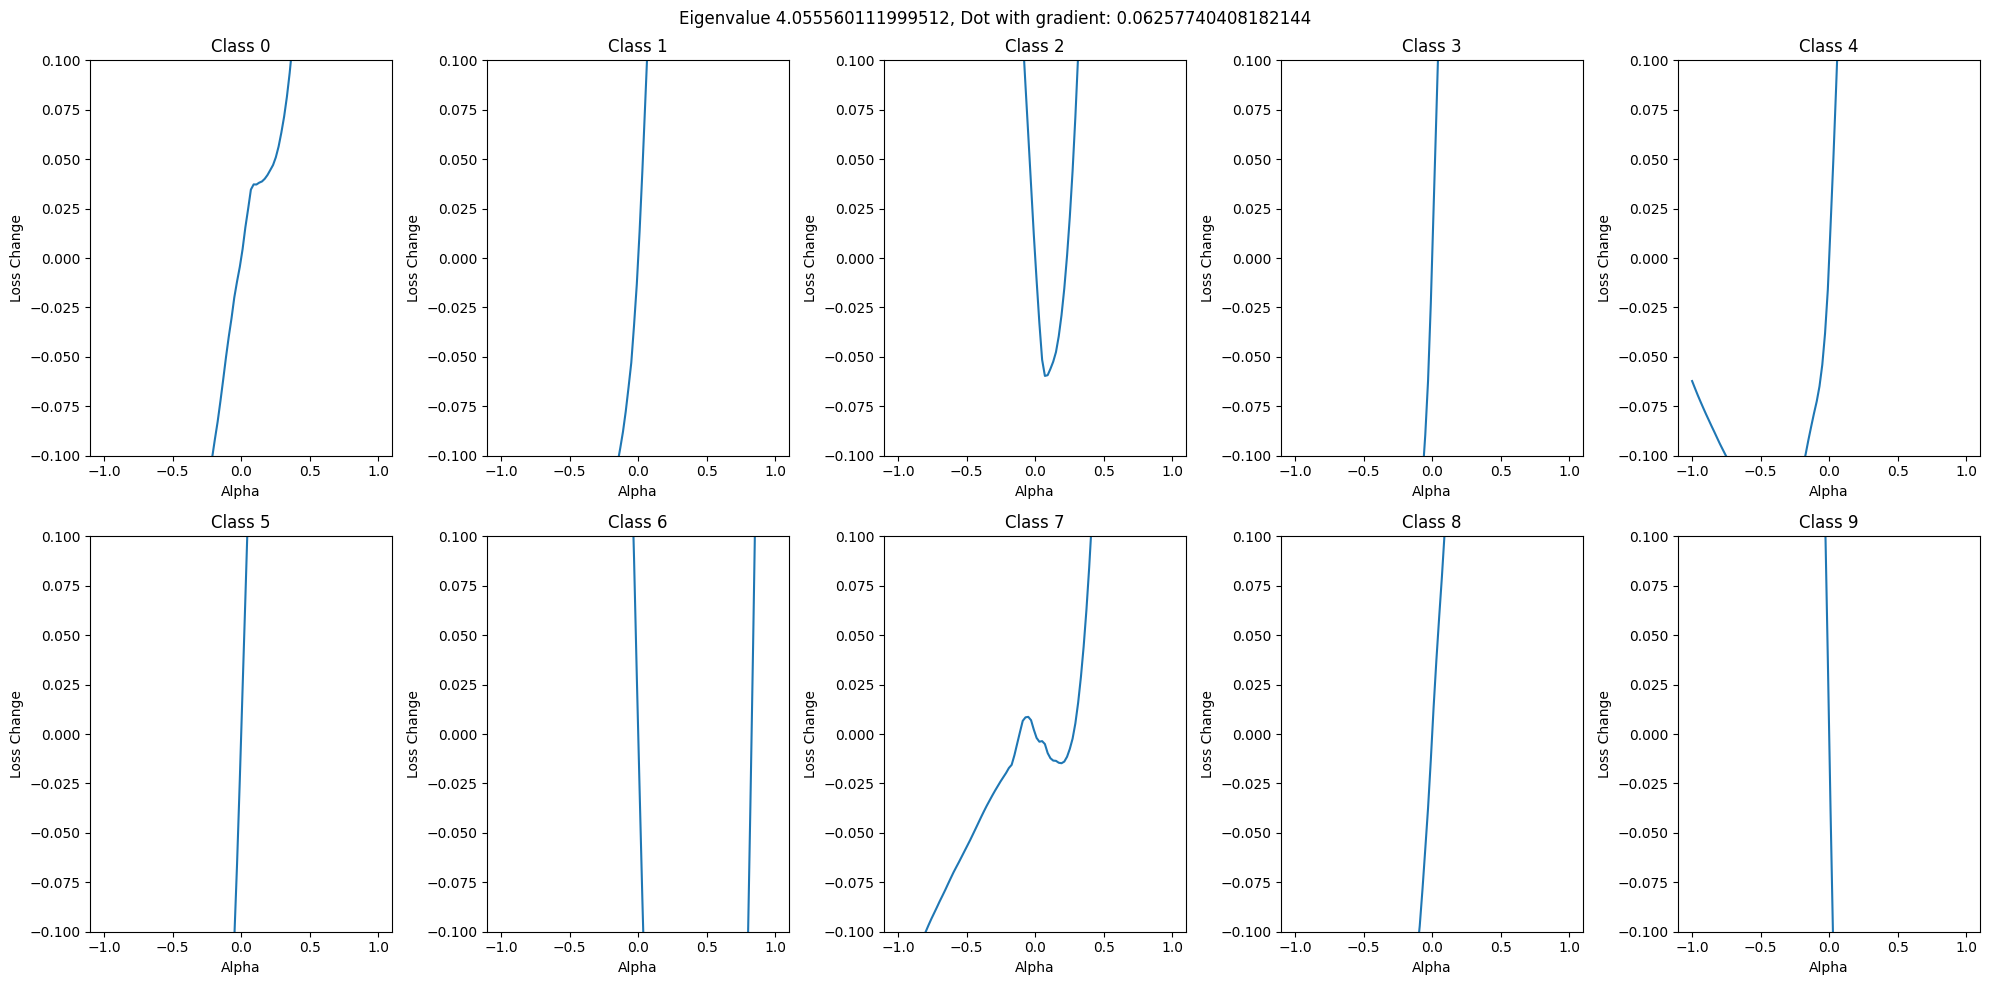

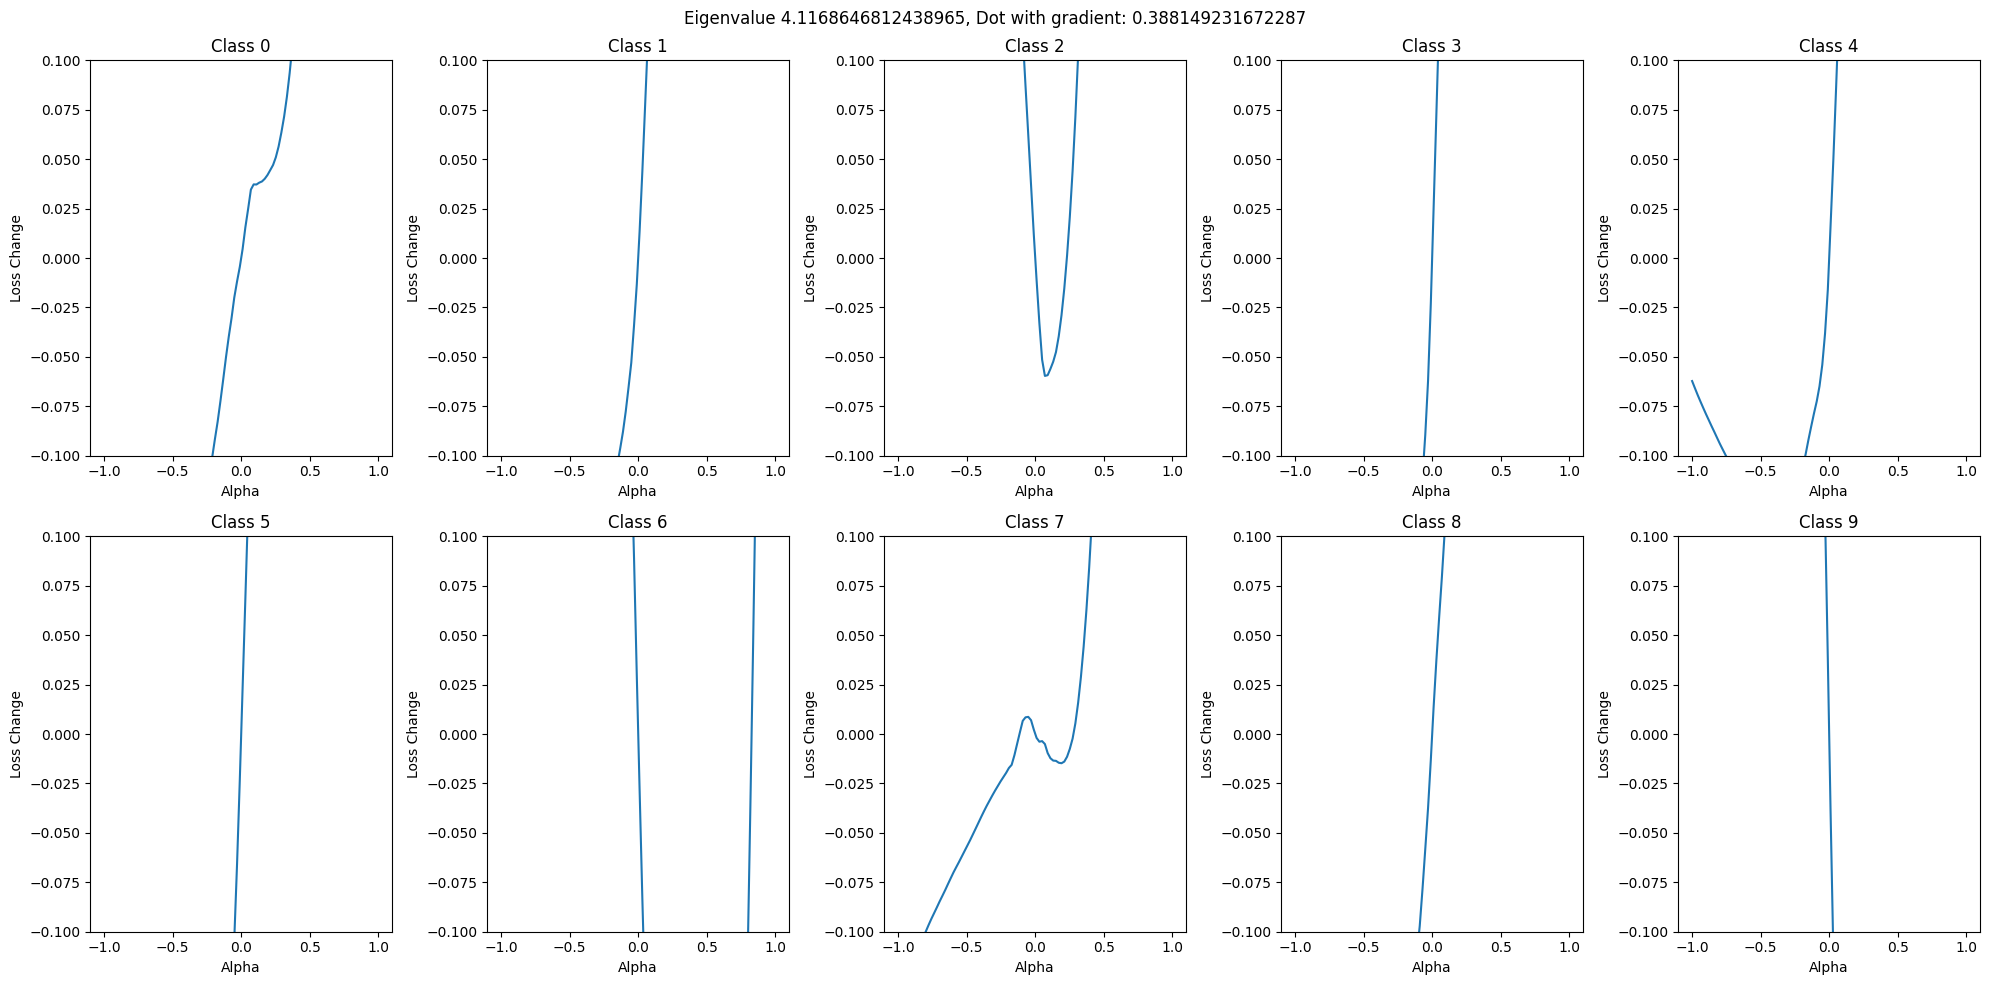

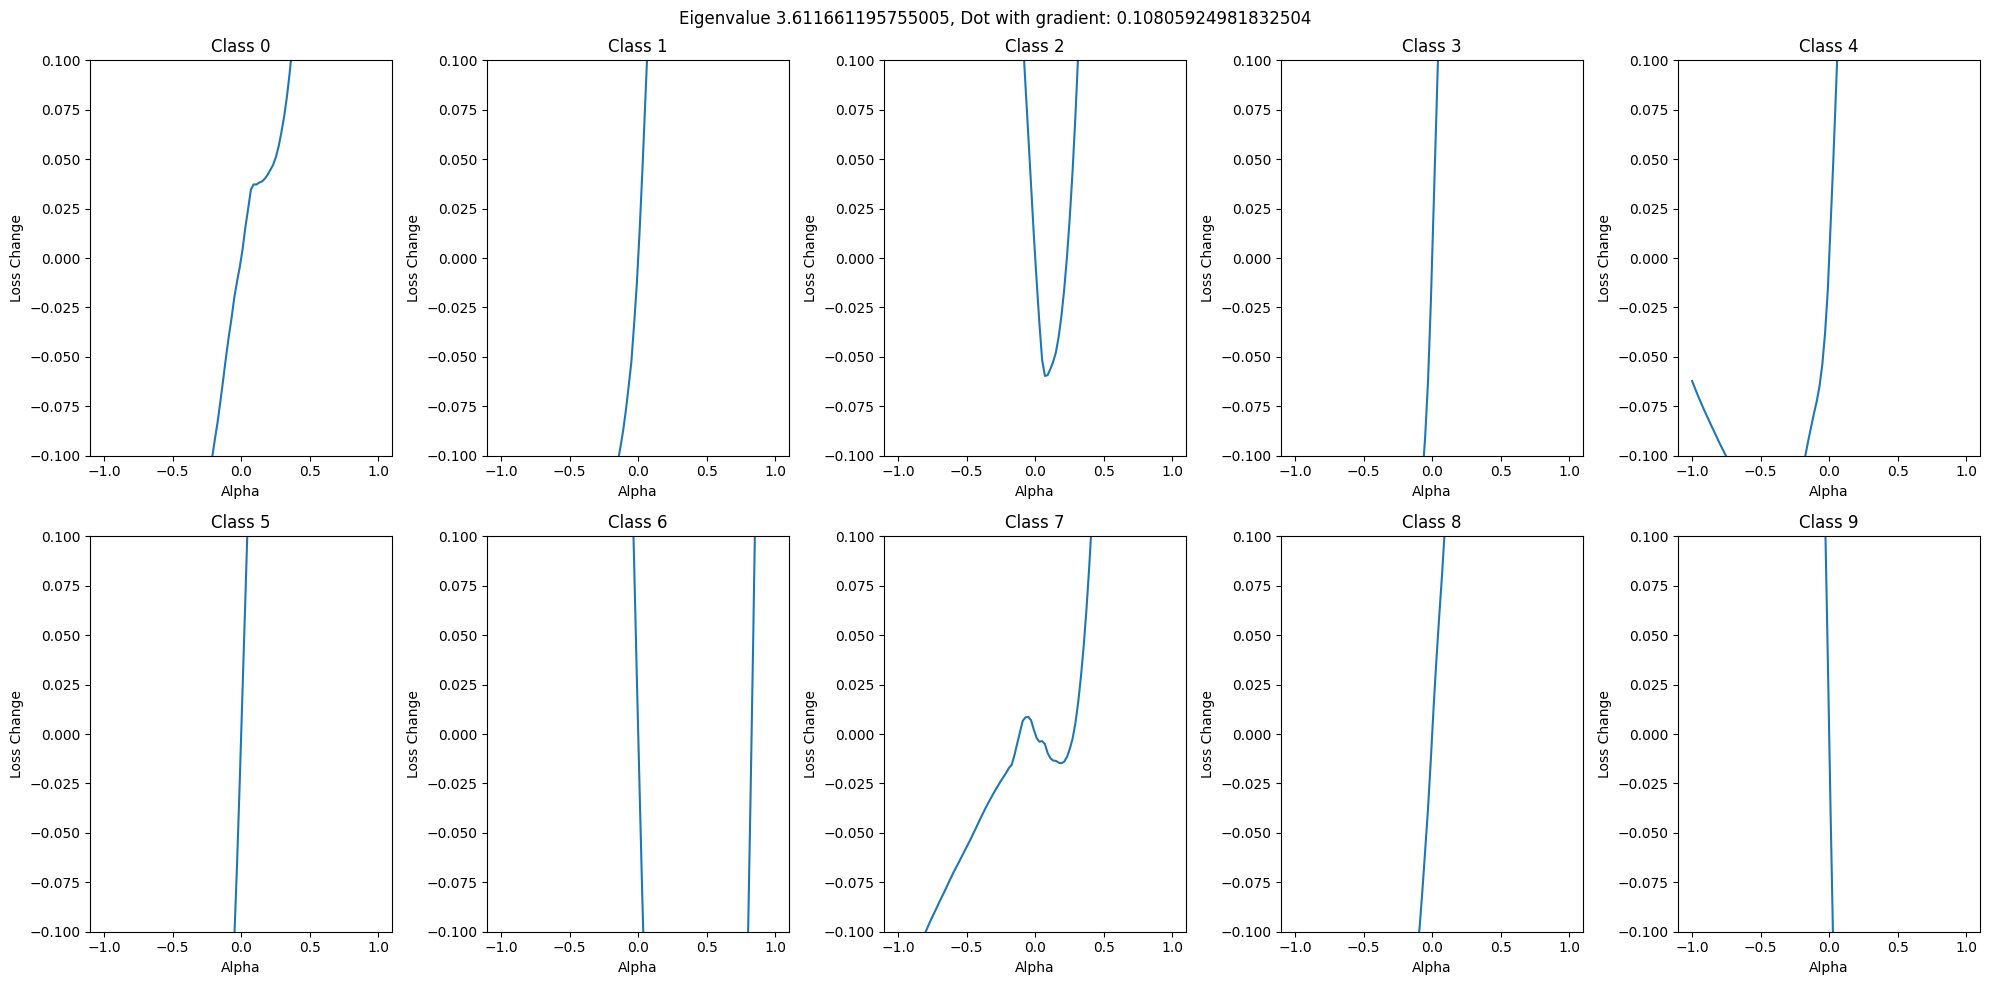

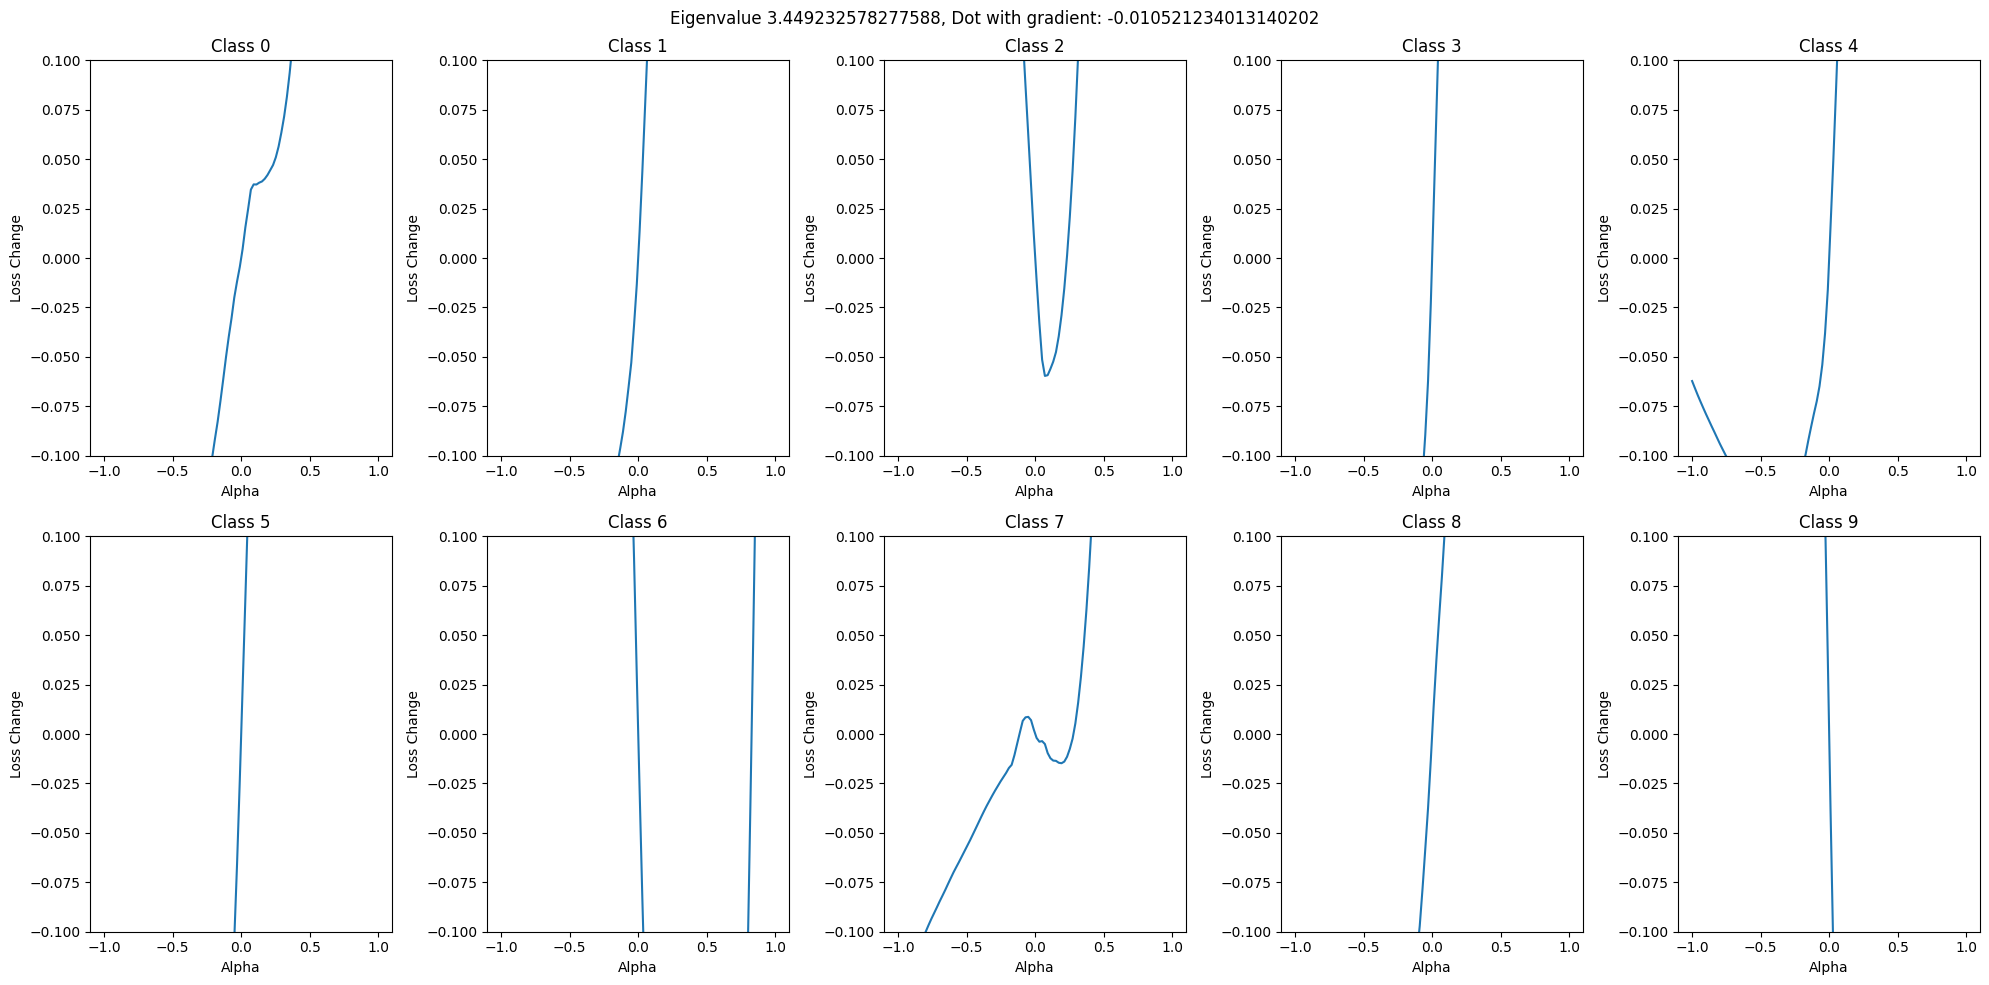

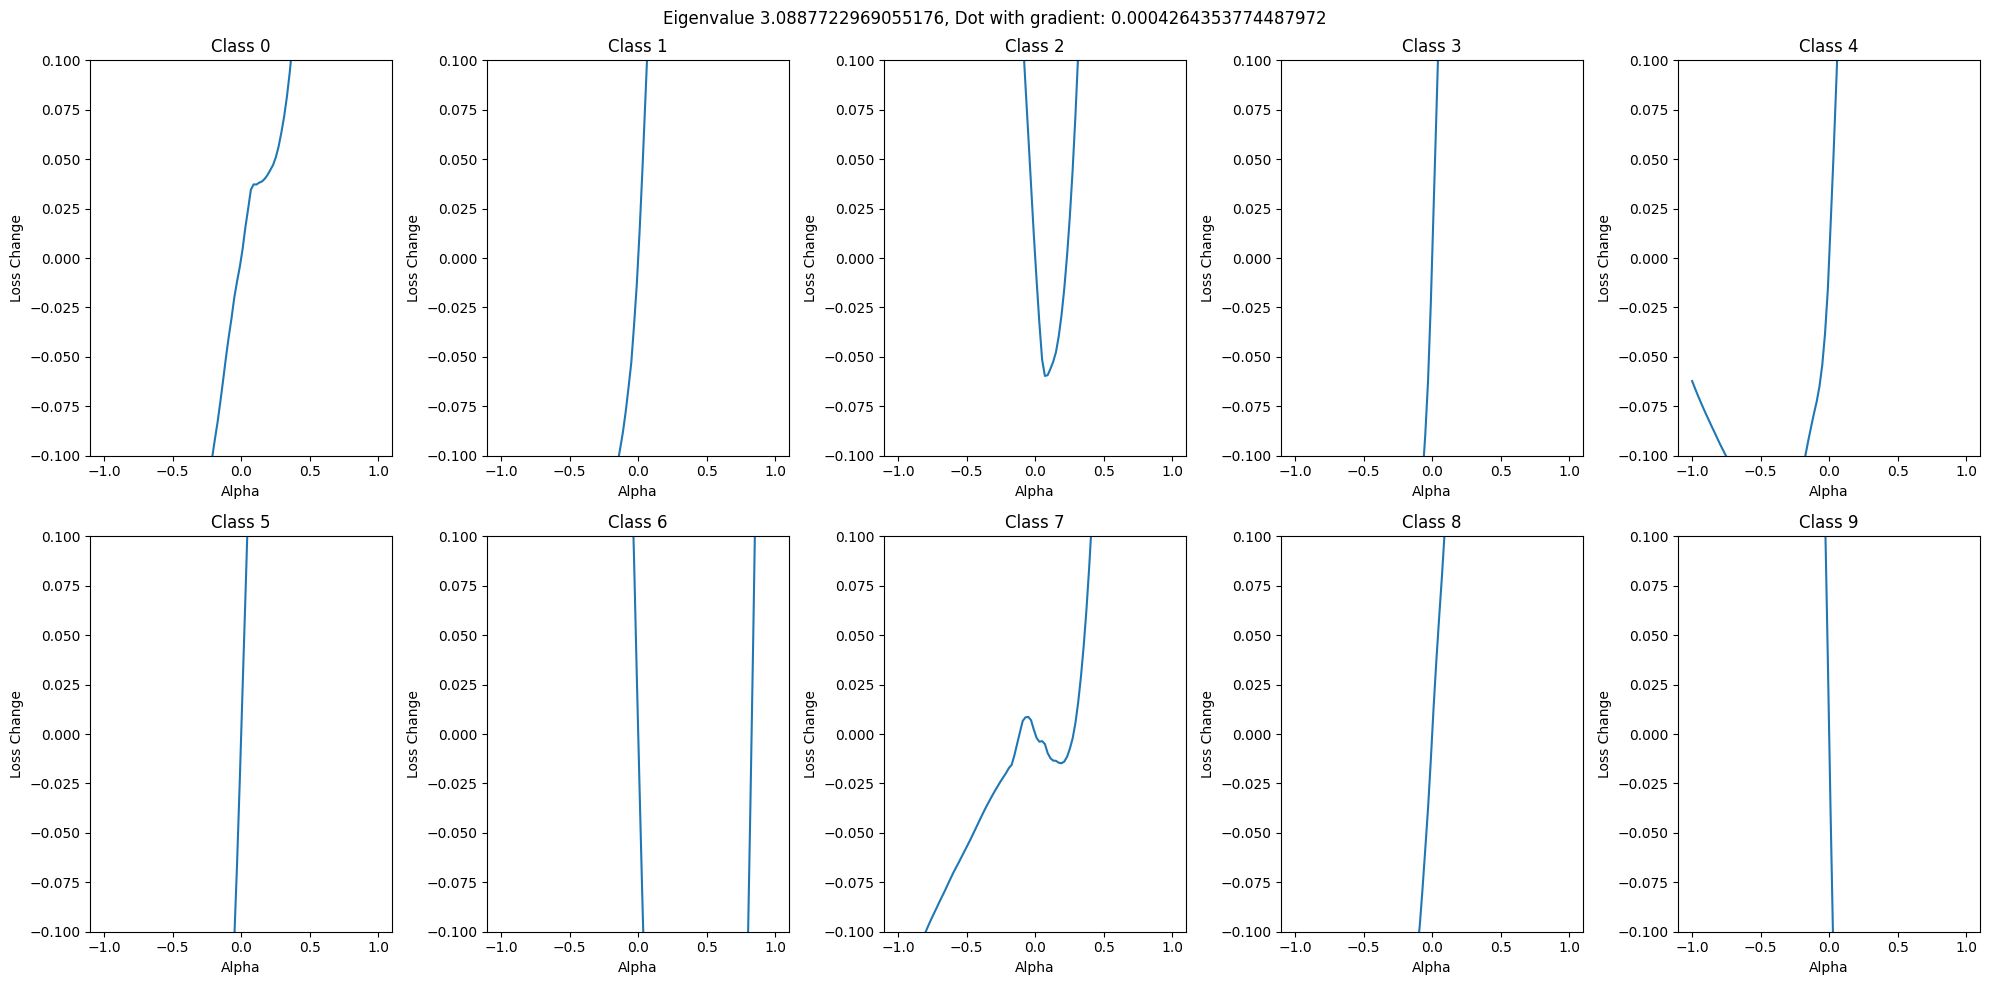

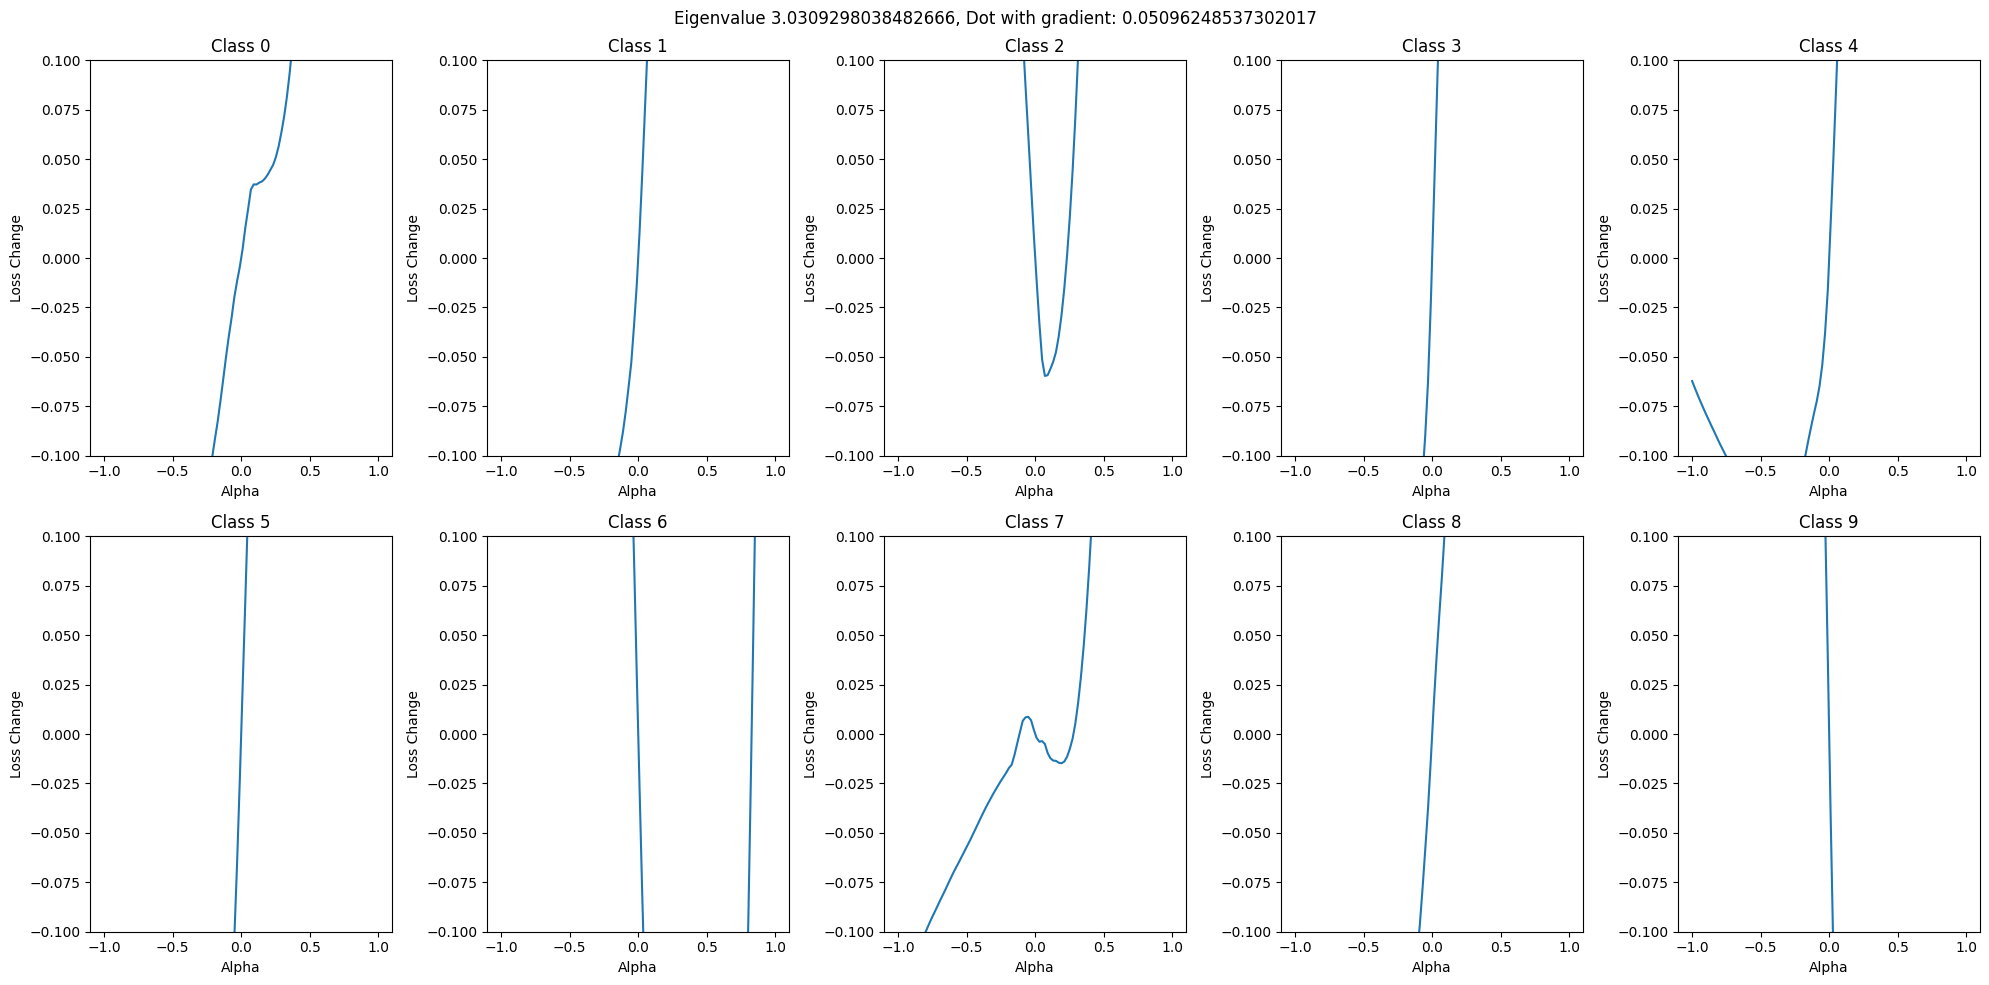

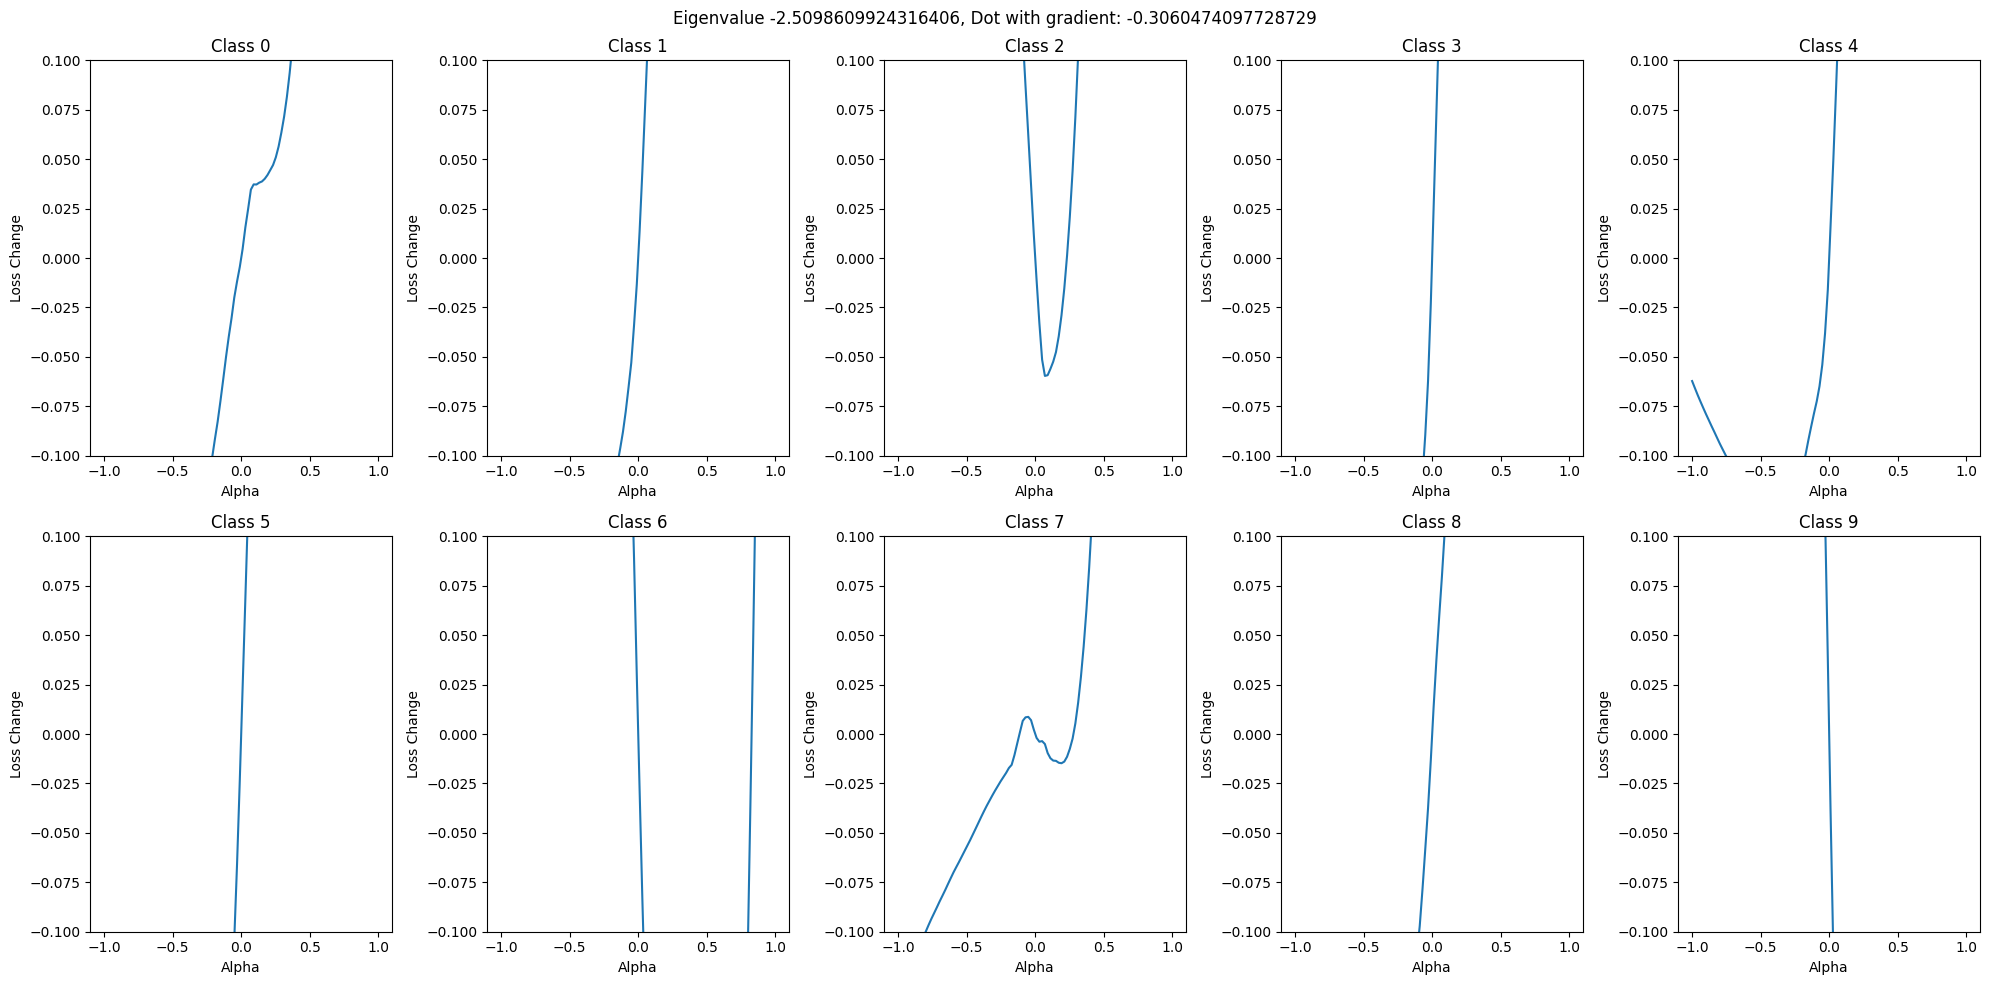

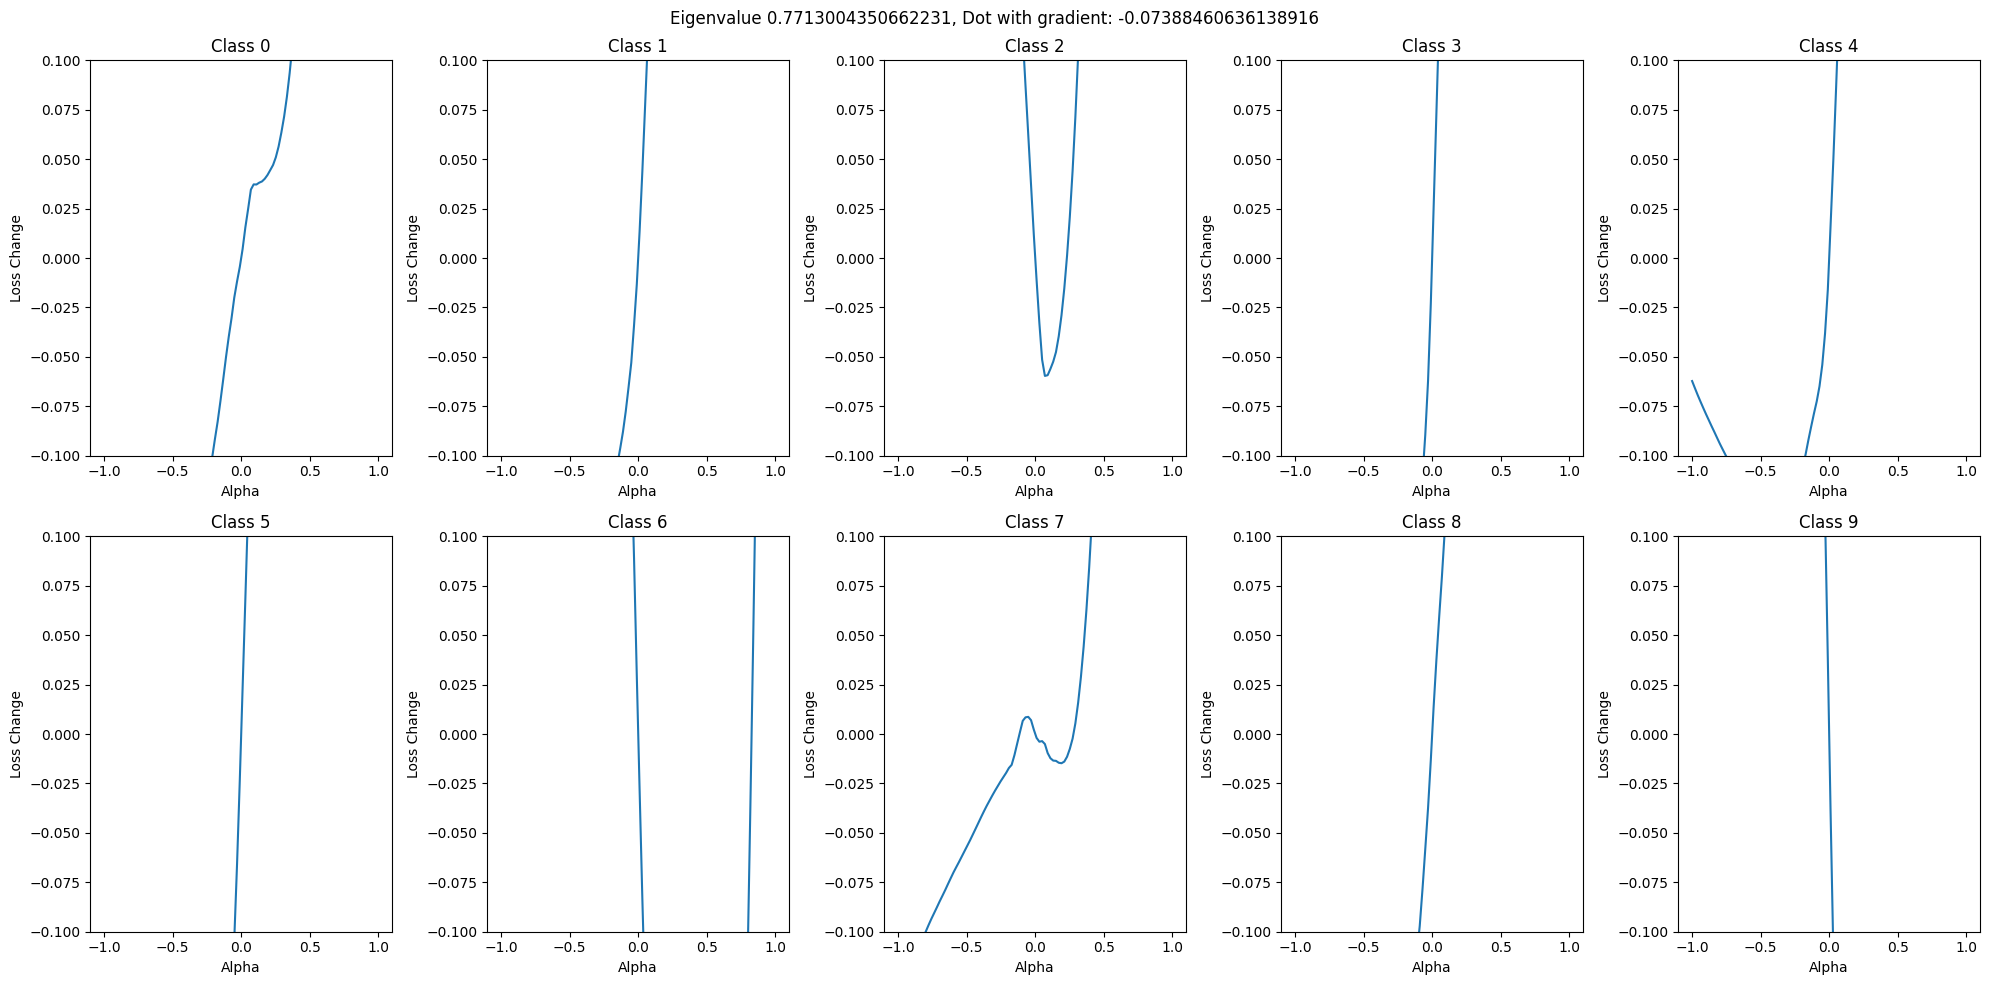

In [73]:
for v, val in zip(vects, vals):
	print()
	hm.perturb_and_plot(vects[0], np.linspace(-1, 1, 100), title=f'Eigenvalue {val}, Dot with gradient: {hm.get_gradient_vector_dot(v)}')

In [67]:
hm.get_gradient_vector_dot(vects[0])

tensor(0.3239)

In [70]:
dots = [(hm.get_gradient_vector_dot(v), val) for v, val in zip(vects, vals)]

In [71]:
dots

[(tensor(0.3239), 5.541697025299072),
 (tensor(0.2850), 4.513429641723633),
 (tensor(0.0626), 4.055560111999512),
 (tensor(0.3881), 4.1168646812438965),
 (tensor(0.1081), 3.611661195755005),
 (tensor(-0.0105), 3.449232578277588),
 (tensor(0.0004), 3.0887722969055176),
 (tensor(0.0510), 3.0309298038482666),
 (tensor(-0.3060), -2.5098609924316406),
 (tensor(-0.0739), 0.7713004350662231)]